# Linear Classifier Perceptrons
In this notebook I have implemented the following:
* Generated a 200-size dataset - 2 sets of 2D points, each is normally distributed (labeled 1/-1)
* 2 techniques of the perceptron algorithm (batch & Stochastic)
* Demostration of finding a linear classifier in a higher dimension (where impossible in $\mathbb{R}^2$)
* A simple kernel function and its advantages

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import time
%matplotlib inline
from IPython.display import display, clear_output
# %matplotlib notebook


First, let's create our dataset:

In [59]:
def plot_2d(dataset, thetas=None, p=None, axes_lim=True):
    %matplotlib inline
    plt.rcParams["figure.figsize"] = (20,13)
    if axes_lim is True:
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
    class_A = dataset[dataset[:,2] == 1]
    class_B = dataset[dataset[:,2] == -1]
    plt.scatter(class_A[:,0], class_A[:,1], color='blue')
    plt.scatter(class_B[:,0], class_B[:,1], color='green')
    if not thetas is None:
        x = np.linspace(-15, 15, 2)
        y = (-thetas[0]*x - thetas[2]) / thetas[1]
        plt.plot(x, y, color='red')
    if not p is None:
        plt.plot(p[0], p[1], 'r*')
    clear_output(wait = True)
    plt.pause(0.01)
    plt.show()

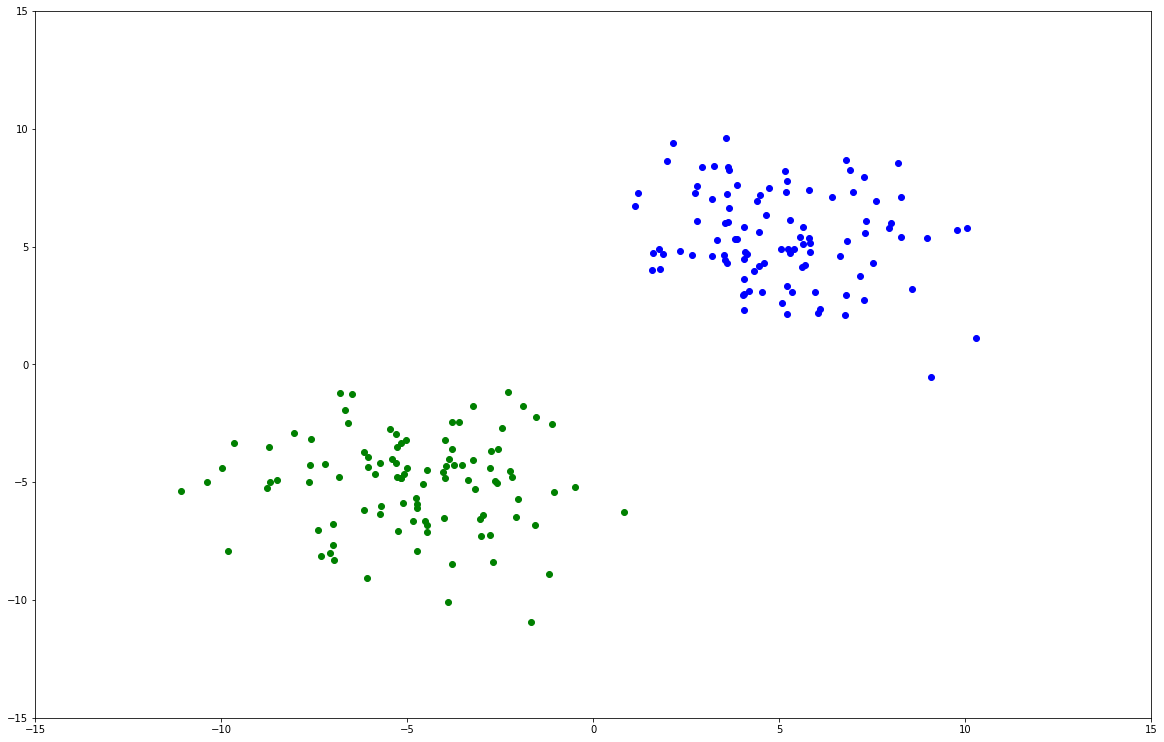

In [49]:
# generating 2 normal disterbuted classes
class_A = np.concatenate((np.random.normal(5, 2, 100).reshape(100, -1),
                          np.random.normal(5, 2, 100).reshape(100, -1),
                          np.ones(100).reshape(100, -1)), axis=1)
class_B = np.concatenate((np.random.normal(-5, 2, 100).reshape(100, -1),
                          np.random.normal(-5, 2, 100).reshape(100, -1),
                          (np.ones(100).reshape(100, -1)) * -1), axis=1)

# concatenate and shuffle
dataset_2d = np.concatenate((class_A, class_B))
np.random.shuffle(dataset_2d)

pd.DataFrame(dataset_2d, columns=['x', 'y', 'class']).describe()

X = dataset_2d[:,:-1]
y = dataset_2d[:,-1]

plot_2d(dataset_2d)

# The Perceptron Algorithm
The Perceptron is an algorithm for supervised learning of binary classifiers, based on a linear predictor function combining a set of weights with the feature vector.

For a given linearly seperabale dataset, the perceptron algorithm will ALWAYS find a sample-consistent classifier.

Consider a dataset of $m$ instences and $n$ features and let $w\in \mathbb{R}^n$ be the weight vector and $b$ the bias.<br>
The execution a algorithm will be:
$$h\left(\overrightarrow{x}\right)=\begin{cases}1 & \overrightarrow{w}\cdot \overrightarrow{x}+b\ge0\\-1 & \overrightarrow{w}\cdot \overrightarrow{x}+b<0\end{cases}$$
Where $\overrightarrow{w}\cdot \overrightarrow{x}$ is the dot product $\sum _{i=1} ^n w_i \cdot x_i$
note: the bias shifts the decision boundary away from the origin and does not depend on any input value.<br><br>
In our case, the classifier will be of the form: $$w_0 x + w_1 y + b = 0$$
So $n=2$ and $m=200$. Let's implement.


In [51]:
def predict(x, w, b):
    return 1 if w @ x + b >= 0 else -1

## Learning proccess

We will implement two different teqnuiue of learning. Stochastic and Batch.<br>
First, let us initialize essential parameters:

In [52]:
def initialize_thetas(random=False):
    # where theta is the vector weights t1,t2,t3 of the linear line t1*x + t2*y + t3*b = 0
    if random:
        thetas = np.random.uniform(low=-1, high=1, size=(3,))
    else:
        thetas = np.array([-1,1,1]).astype('float64')

    return thetas


thetas = initialize_thetas()

# set learning rate
lr_stochastic = .01
lr_batch = .0006


note that our weight vector $w$ is defined as $\Theta$, including the bias which is $\Theta_2$.

## Stochastic Perceptron
This technique evaluates and updates the weights every iteration.

The way this optimization algorithm works is that each training instance is shown to the model one at a time. The model makes a prediction for a training instance, and will be updated if it is misclassified.<br>

Basically, the learning process will be:<br><br>
Initialize $w$ randomly<br>
Repeat until convergence/fixed number of iterations:<br>

&emsp; Foreach $x^{(d)}\in X$<br>
&emsp;&emsp; $o^{(d)} = sgn(w\cdot x^{(d)} + b) \left( = h(x^{(d)})\right)$<br>
&emsp;&emsp; Foreach $w_i\in w$ update:<br>
&emsp;&emsp;&emsp; $w_i = w_i -\eta (o^{(d)} - t^{(d)})\cdot x_i^{(d)}$<br>
&emsp;&emsp;&emsp; $b = -\eta (o^{(d)} - t^{(d)})$<br>

Where $\eta$ is the learning rate, $o^{(d)}$ is the prediction of instance $x^{(d)}$ with target/label $t^{(d)} \in \{-1,1\}$.<br><br>
Note that if the prediction is corrent, then $o^{(d)} - t^{(d)} = 0$, so no change of weights. <br>
If not, the classfier needs to be updated towards the sign of $(o^{(d)} - t^{(d)})$.




Our dataset consisted of 2 classes detributed normally each. Setting a descent learning rate, we can find the classifier iterating a few times over each instance.<br>
Initializing our weight vector $w$ to [-1,1,1] (defined as $\Theta$).<br><br>
reminder: our linear line is of the form $\Theta_0 x + \Theta_1 y + \Theta_2 b = 0$

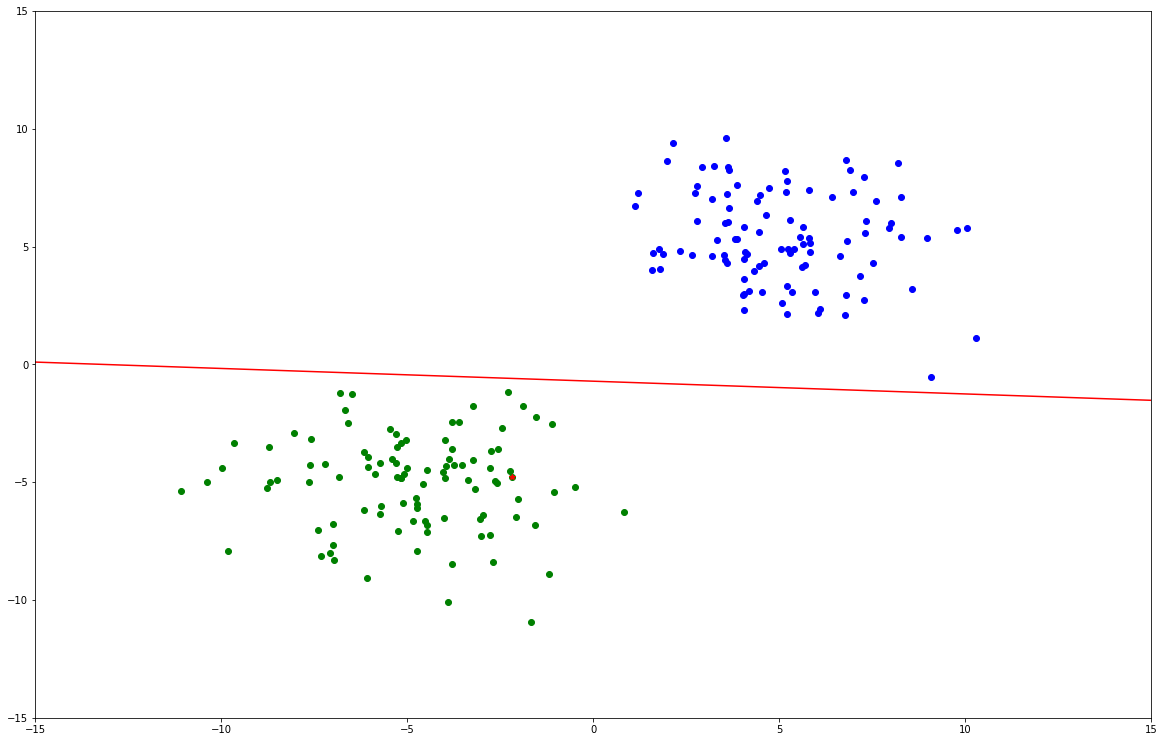

final thetats: [0.07307621 1.35090506 0.96      ]


In [53]:
# stochastic perceptron

thetas = initialize_thetas()
iterations = 5

def stochastic_perceptron(thetas, iterations):
    for i in range(iterations):
        for row in list(zip(X,y)):
            p = row[0]
            t = row[1]
            thetas = update_single_point(p, t, thetas, lr_stochastic)
            plot_2d(dataset_2d, thetas, p)
    print('final thetats:', thetas)


def update_single_point(p, t, thetas, lr):
    """
    updates thetas related to an instance p
    """
    update_value = predict(p, thetas[:-1], thetas[-1]) - t # either -1, 0 (if classified correctly), or 1
    thetas[:-1] -= lr * p * update_value
    thetas[-1] -= lr * update_value # update bias
    
    return thetas


stochastic_perceptron(thetas, iterations)

Note: running time is slow due to plotting for every instance. Can be improved easily by filtering only misclassifications.

## Batch Perceptron
In batch learning the model update is performed after observing the entire training set.
The learning algorithm in our case will be:<br><br>
Initialize $w$ randomly<br>
Repeat until convergence/fixed number of iterations:<br>
&emsp; Foreach $x^{(d)}\in X$<br>
&emsp;&emsp;&emsp; $o^{(d)} = sgn(w\cdot x^{(d)} + b)$<br>
&emsp;&emsp;&emsp; Foreach $w_i\in w$ update:<br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\Delta w_i = -\eta \sum_{d\in D}(o^{(d)} - t^{(d)})\cdot x_i^{(d)}$<br>
&emsp;&emsp;&emsp; $b = -\eta \sum_{d\in D}(o^{(d)} - t^{(d)})$<br>
&emsp;&emsp;&emsp; $w = w + \Delta w$<br>

Let's implement:

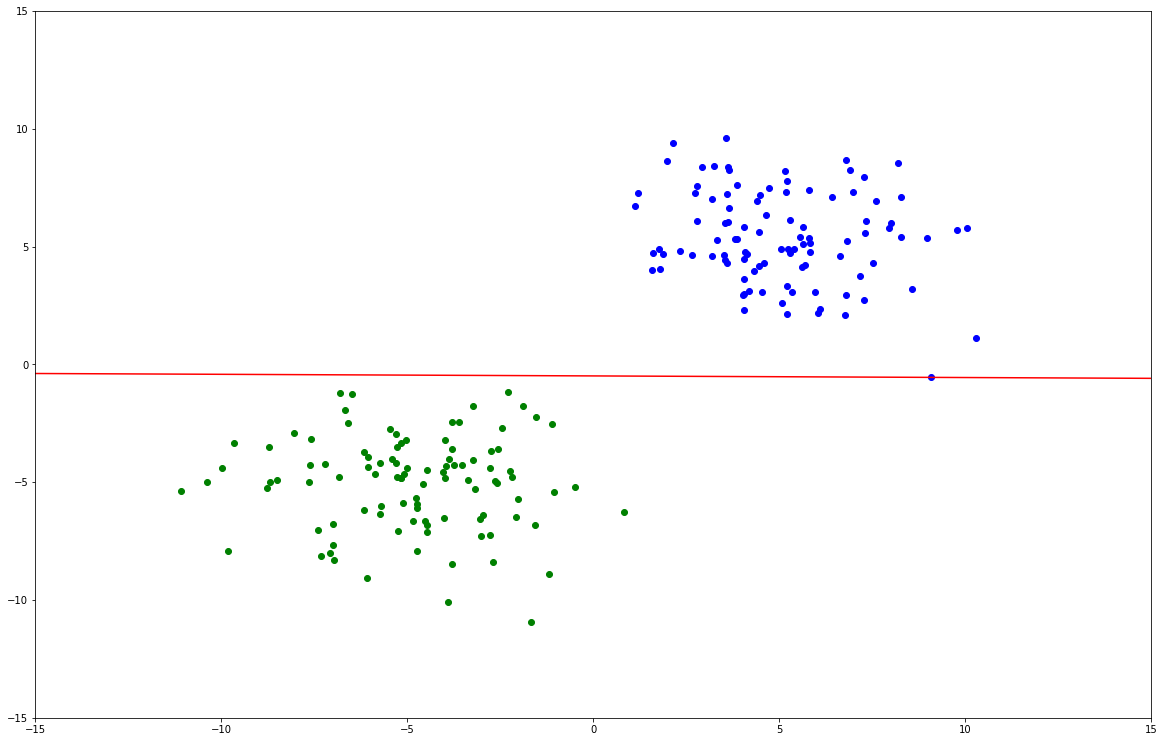

final thetas: [0.01377921 2.01377921 0.9796    ]


In [54]:
# batch perceptron

thetas = initialize_thetas()
iterations = 100

def batch_perceptron(thetas, iterations):
    plot_2d(dataset_2d, thetas)
    for i in range(iterations):
        thetas = update_thetas(X, y, thetas, lr_batch)
#         print(thetas)
        plot_2d(dataset_2d, thetas)
    print('final thetas:', thetas)
    
    
def update_thetas(X, y, thetas, lr):
    thetas += np.apply_along_axis(lambda row: get_delta_theta(row, thetas, lr), 1, dataset_2d).sum(axis=0)
    return thetas


def get_delta_theta(row, thetas, lr):
    p = np.array(row[:-1])
    t = row[2]
    delta_theta = np.zeros(3)
    update_value = predict(p, thetas[:-1], thetas[-1]) - t # either -1, 0 (if classified correctly), or 1
    delta_theta[:-1] -= lr*p[:-1]*update_value
    delta_theta[-1] -= lr*update_value # update bias
    
    return delta_theta

batch_perceptron(thetas, iterations)

## The Dual Perceptron
In order to derive a kernelized version of the perceptron algorithm (shall be explained in details later), we must first formulate it in a dual form.<br>
As mentioned before, the decision function is: $$C(\overrightarrow{x}) = sgn \left(\overrightarrow{w}\cdot \overrightarrow{x} + b\right) = sgn \left( \left(\sum _{i=1} ^n w_i \cdot x_i\right) + b\right)$$
Where for every iteration over $x_{id}$ we get $\overrightarrow{w_i} = w_{i}-\eta\left(o_{d}-t_{d}\right)\cdot x_{id}$. <br><br>
To simplefy, every iteration we add a small fraction of $t_d\cdot x_d$ if it is misclassified (we multiply by $t_d$ to set the sign).<br><br>
Let $\alpha_d$ be the $\left((number\, of\, misclassifications) \times \eta\right)$ of instance $x_d$ during the learning proccess.<br>
So we get:
$$\overrightarrow{w}\cdot \overrightarrow{x} =
\left(\sum_{x_d\in X} \alpha_d t_d \overrightarrow{x_d}\right) \cdot \overrightarrow{x}=
\sum_{x_d\in X} \alpha_d t_d \left(\overrightarrow{x_d} \cdot \overrightarrow{x}\right)$$

So the duel perceptron algorithm would be:<br><br>
Initialize for all $1\le i\le m, \alpha_i = 0$<br>
Repeat until convergence/fixed number of iterations:<br>
&emsp; Foreach $x^{(d)}\in X$<br>
&emsp;&emsp;&emsp; $o_d = \sum_{i=1} ^m \alpha_i t_i \left(\overrightarrow{x_i} \cdot \overrightarrow{x_d}\right)$<br>
&emsp;&emsp;&emsp; If $o_dt_d < 0$ update: // a misclassification<br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha_d = \alpha_d + \eta$<br><br>

To conclude, for a given new instance $\overrightarrow{x}$, the decision function will be:
$$C\left(\overrightarrow{x}\right)=\sum_{x_d\in X}\alpha_{i}t_{i}\left(\overrightarrow{x}\cdot\overrightarrow{x_{d}}\right)$$

Note: When dealing with linear seperable datasets, the dual from will be preferred only when $n >> m$.<br>
Let's implement:

In [10]:
# init eta and numbert of interations
eta = 1
iterations = 200

def predict_dual(x, alphas, data):
    return 1 if (alphas[:-1] * data[:,-1] * (data[:,:-1] @ x)).sum() + alphas[-1] >= 0 else -1

def dual_perceptron(data, iterations=5, predict_func=predict_dual):
    alphas = np.zeros(data.shape[0] + 1) # init alphas vector (+1 for bias)
    for i in range(iterations):
        delta_alphas = np.zeros(data.shape[0] + 1)
        for j in range(data.shape[0]):
            x = data[j][:-1]
            target = data[j][-1]
            prediction = predict_func(x, alphas, data)
#             print('pred:', prediction, 'target:', target)
            if prediction * target < 0:
                delta_alphas[j] += eta
                delta_alphas[-1] += eta * target # set direction of bias
        alphas += delta_alphas
    return alphas

In [11]:
# tests
def dual_perceptron_test(train_data, iterations, test_data, predict_func=predict_dual):
    alphas = dual_perceptron(train_data, iterations, predict_func) # train
    
    correct_pred = 0
    for x in test_data:
        correct_pred += x[-1] == predict_func(x[:-1], alphas, train_data)
    print('accuracy rate:', correct_pred / test_data.shape[0])


In [55]:
alphas_2d = dual_perceptron(dataset_2d, iterations)

dual_perceptron_test(dataset_2d, iterations, dataset_2d) # on all train data
dual_perceptron_test(dataset_2d[:-20], iterations, dataset_2d[-20:]) # train-test split 10% as test

accuracy rate: 1.0
accuracy rate: 1.0


Let's plot our result.<br>
First, we need to extract the weight vector $\overrightarrow{w}$.
Since $\left(\overrightarrow{w} =
\sum_{x_d\in X} \alpha_d t_d \overrightarrow{x_d}\right)$ we get:


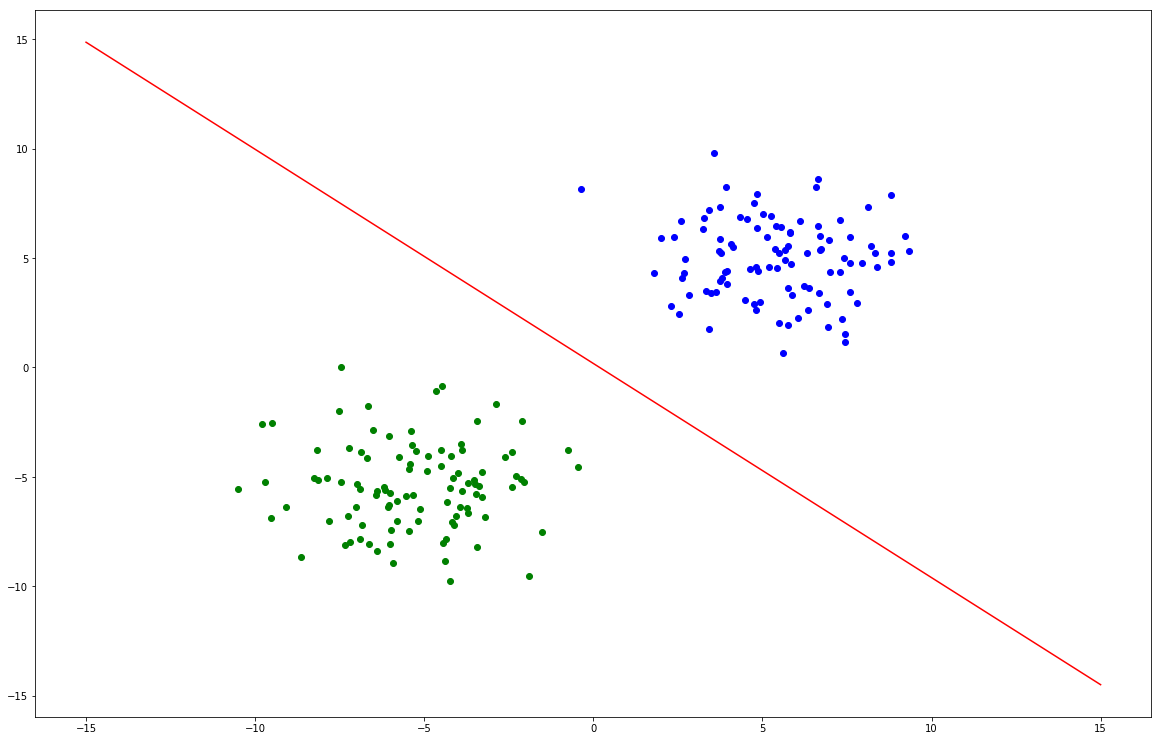

In [14]:
X = dataset_2d[:,:-1]
targets = dataset_2d[:,2]
thetas_2d_dual = np.zeros(3)
thetas_2d_dual[-1] = alphas_2d[-1] # b
thetas_2d_dual[:-1] = (alphas_2d[:-1] * targets) @ X # w

plot_2d(dataset_2d, thetas_2d_dual)

# Higher Dimension Mapping
What if our data is not linearly seperable?
Consider the following detribution of this 2-class dataset:

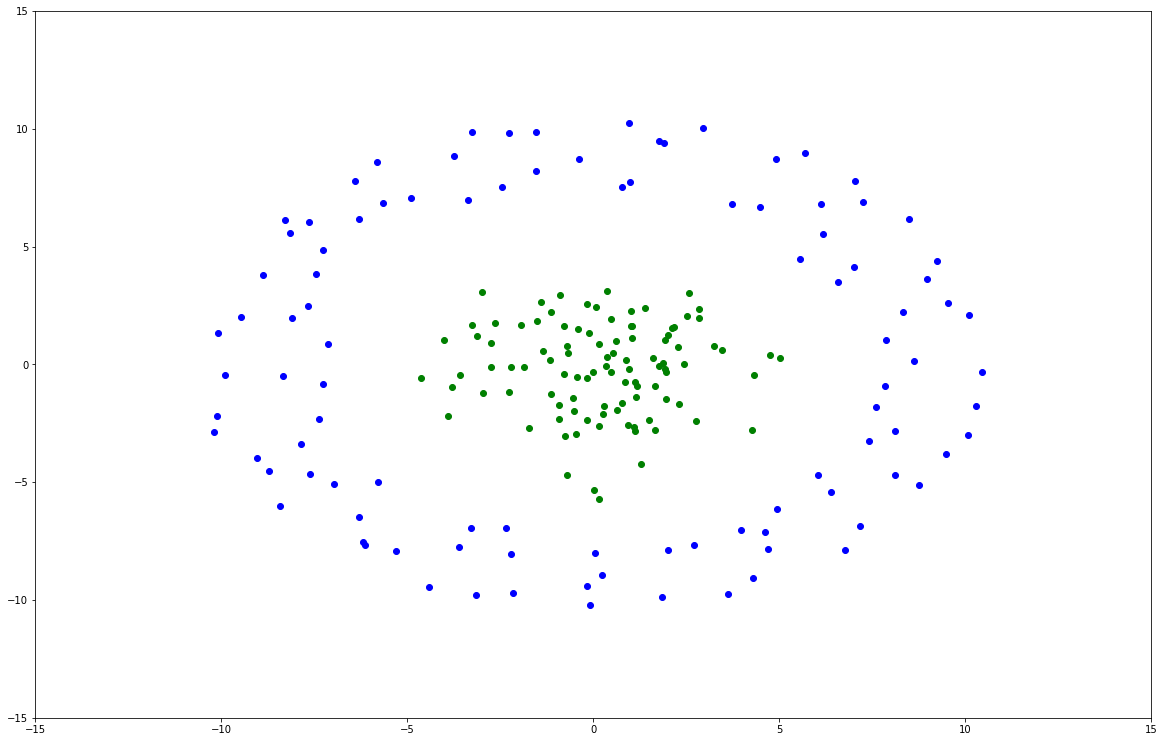

In [41]:
from sklearn.datasets import make_circles

# generating 2 new classes
class_C = np.concatenate((np.random.normal(0, 2, 100).reshape(100, -1),
                          np.random.normal(0, 2, 100).reshape(100, -1),
                          (np.ones(100).reshape(100, -1) * -1)), axis=1)

class_D = np.concatenate((make_circles(n_samples=100, noise=.05)[0] * 10, (np.ones(100).reshape(100, -1))), axis=1)

# concatenate and shuffle
dataset_circles = np.concatenate((class_C, class_D))
np.random.shuffle(dataset_circles)

X = dataset_circles[:,:-1]
y = dataset_circles[:,-1]

plot_2d(dataset_circles)

Clearly this dataset is not linearly seperable. How can we manipulate the data and make it lineanrly seperable? Our data is in $\mathbb{R}^2$. Maybe it is linearly seperable in a higher dimension. How about $\mathbb{R}^3$?<br>
Let $\varphi: \mathbb{R}^2\rightarrow\mathbb{R}^3$ be the following linear mapping: $$\varphi({x_1,x_2})=(x_1,x_2,x_1^2 + x_2^2)$$
Let's implement:

In [6]:
def phi(x):
    third = np.power(x[0], 2) + np.power(x[1], 2)
    return np.append(x[:2], [third, x[-1]])

Using the duel form, we can now find a linear classifier in $\mathbb{R}^3$. the only difference will be in the decision function:
$$o_d = \sum_{i=1} ^m \alpha_i t_i \left(\overrightarrow{x_i} \cdot \overrightarrow{x_d}\right) \Longrightarrow o_d = \sum_{i=1} ^m \alpha_i t_i \left(\varphi\left(\overrightarrow{x_i}\right) \cdot \varphi\left(\overrightarrow{x_d}\right)\right)$$
For simplicity, we'll apply $\varphi$ on the whole dataset.<br> 
Let's implement:

In [7]:
def predict_phi(x, alphas, data):
    mapped_data = np.apply_along_axis(lambda instance: phi(instance), 1, data)
    mapped_x = phi(x)
    return 1 if (alphas[:-1] * data[:,-1] * (mapped_data[:,:-1] @ mapped_x[:-1])).sum() + alphas[-1] >= 0 else -1

Measuring the learning preccess time:

In [28]:
%time alphas_3d = dual_perceptron(dataset_circles, iterations, predict_phi)

CPU times: user 1min 32s, sys: 214 ms, total: 1min 32s
Wall time: 1min 32s


In [49]:
# test
dual_perceptron_test(dataset_circles, iterations, dataset_circles, predict_phi)

accuracy rate: 1.0


Note: every iteration the method predict_phi is applied, $data\_circles$ is mapped to $\mathbb{R}^2$ (inefficient.. but follows the algorithm).<br>

### Improving Performence
Mapping the whole data *before* training will improve perfomence:

In [43]:
# now our data is 3-dim (x_d => phi(x_d) forall x_d in X)
dataset_3d = np.apply_along_axis(lambda instance: phi(instance), 1, dataset_circles)

In order to denostrate, let's plot the 3d plot.<br>
Note that the drawn hyperplane is only for demonstration, hard-coded.

In [26]:
from mpl_toolkits.mplot3d import Axes3D
    
def plot_3d(mapped_data):
    %matplotlib notebook
    ax = Axes3D(plt.figure(figsize=(10,7)))

    class_C = mapped_data[mapped_data[:,-1] == -1]
    class_D = mapped_data[mapped_data[:,-1] == 1]
    
    ax.scatter(class_C[:,0], class_C[:,1], class_C[:,2], color='green')
    ax.scatter(class_D[:,0], class_D[:,1], class_D[:,2], color='blue')

# uncomment to plot hyperplane
    x_min, x_max = plt.gca().get_xlim()
    x_grid_gap = np.diff(plt.gca().get_xticks()[:2])[0]
    y_min, y_max = plt.gca().get_ylim()
    y_grid_gap = np.diff(plt.gca().get_yticks()[:2])[0]
    
    x = np.arange(x_min, x_max, x_grid_gap)
    y = np.arange(y_min, y_max, y_grid_gap)
    Xi, Yi = np.meshgrid(x, y)
    Zi = np.full((Xi.shape), 40)
    ax.plot_surface(Xi, Yi, Zi, color='grey', alpha=0.5)

    plt.show()

<IPython.core.display.Javascript object>


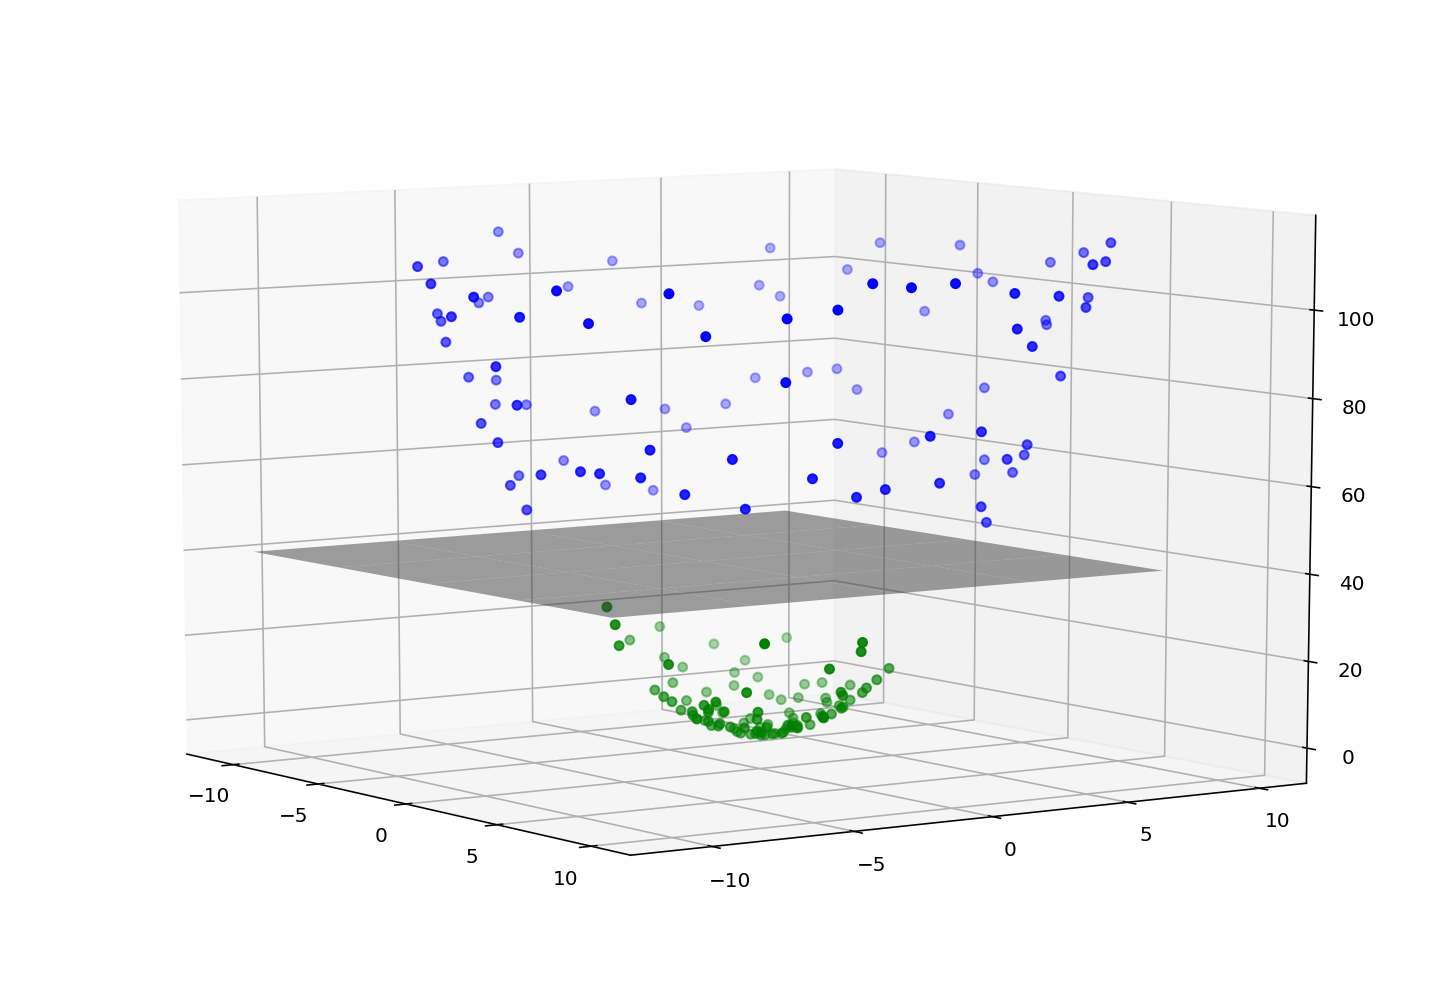

In [44]:
plot_3d(dataset_3d)

Now let's train and test the model using our 3d mapped dataset (notice the time differance):<br>
Note: Since our dataset is already in $\mathbb{R}^3$, we can use $precict\_dual()$

In [45]:
%time alphas_3d = dual_perceptron(dataset_3d, iterations, predict_func=predict_dual)

CPU times: user 425 ms, sys: 3.59 ms, total: 429 ms
Wall time: 427 ms


In [46]:
# test on train data
dual_perceptron_test(dataset_3d, iterations, dataset_3d)

accuracy rate: 1.0


<b>Note</b>: for later imlemetations we will not use the mapped dataset ($dataset_3d$), in order to compare performance with the kernel function.

Like before, the weight vector which represents the hyperplane ($w$) is equal to: $\sum_{x_d\in X} \alpha_d t_d \varphi\left(\overrightarrow{x_d}\right)$<br>
Since our decision function is: $C(x) = sgn\left(\sum_{x_d\in X} \alpha_d t_d \left(\varphi\left(\overrightarrow{x_d}\right) \cdot \varphi\left(\overrightarrow{x}\right) \right) + b\right)$, if we scale our dataset by $\sum_{x_d\in X} \alpha_d t_d \varphi\left(\overrightarrow{x_d}\right)$, our classifier will be the $z$-axes (only for demonstration):

<IPython.core.display.Javascript object>


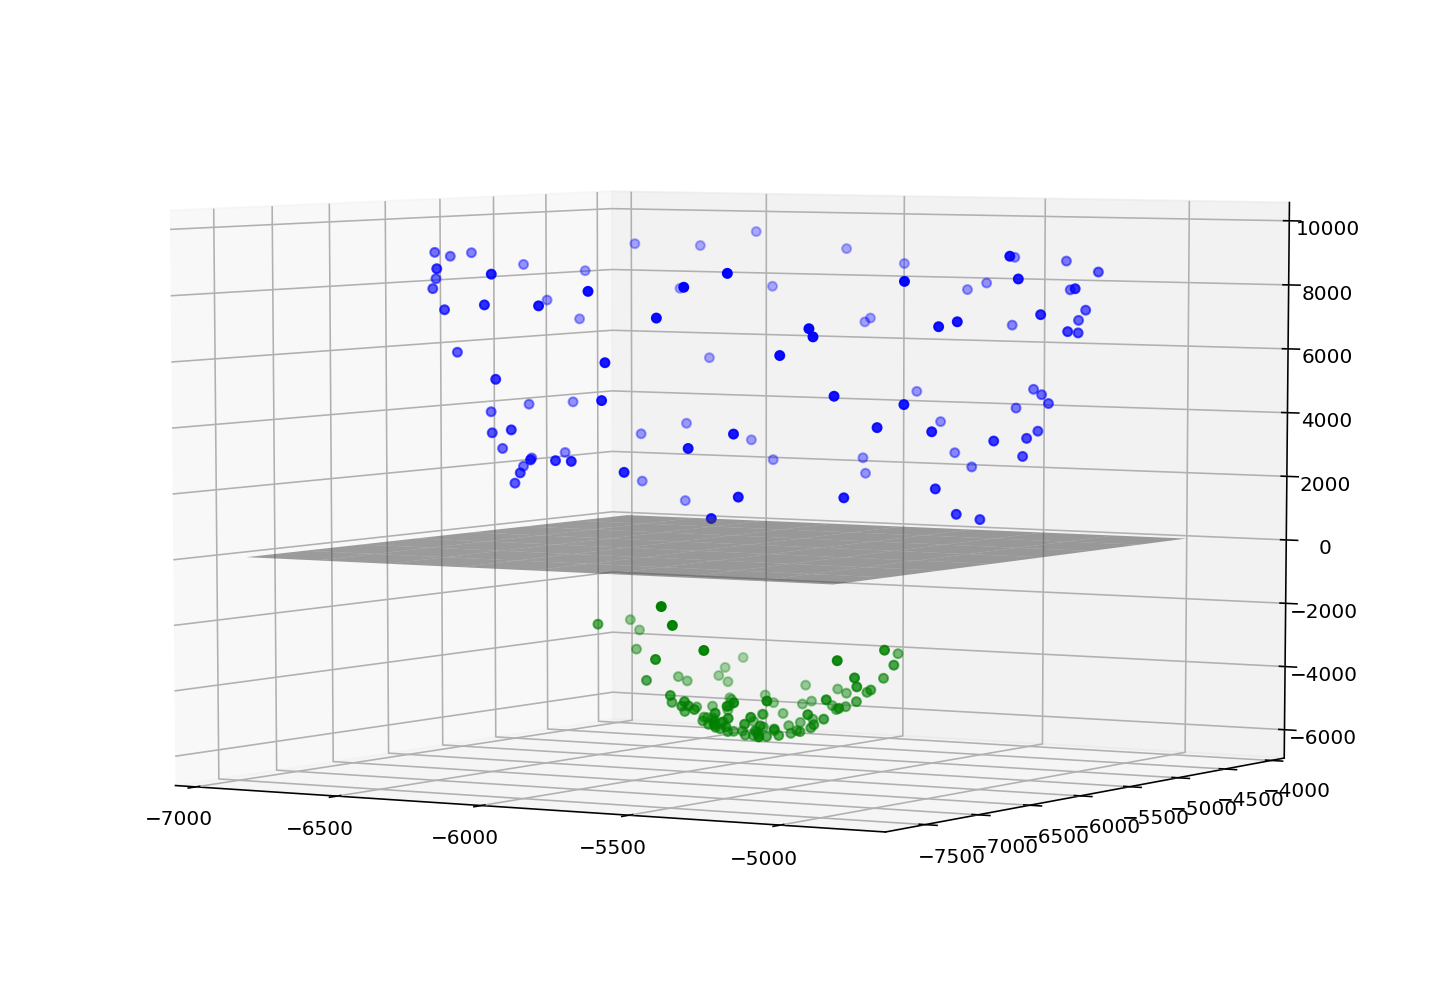

In [47]:
sacled_data = dataset_3d
sacled_data[:,:-1] = dataset_3d[:,:-1] * ((alphas_3d[:-1] * dataset_3d[:,-1]) @ dataset_3d[:,:-1]) + alphas_3d[-1]

# plotting
plot_3d(sacled_data)

A brief look at the plot, be can deduce that for all $x_d \in X, Class\left(\overrightarrow{x_d}\right) = sgn(x_{d3})$. <br>
Set $\overrightarrow{w} = (0,0,1)$ and $b = 0$ we get:

<IPython.core.display.Javascript object>


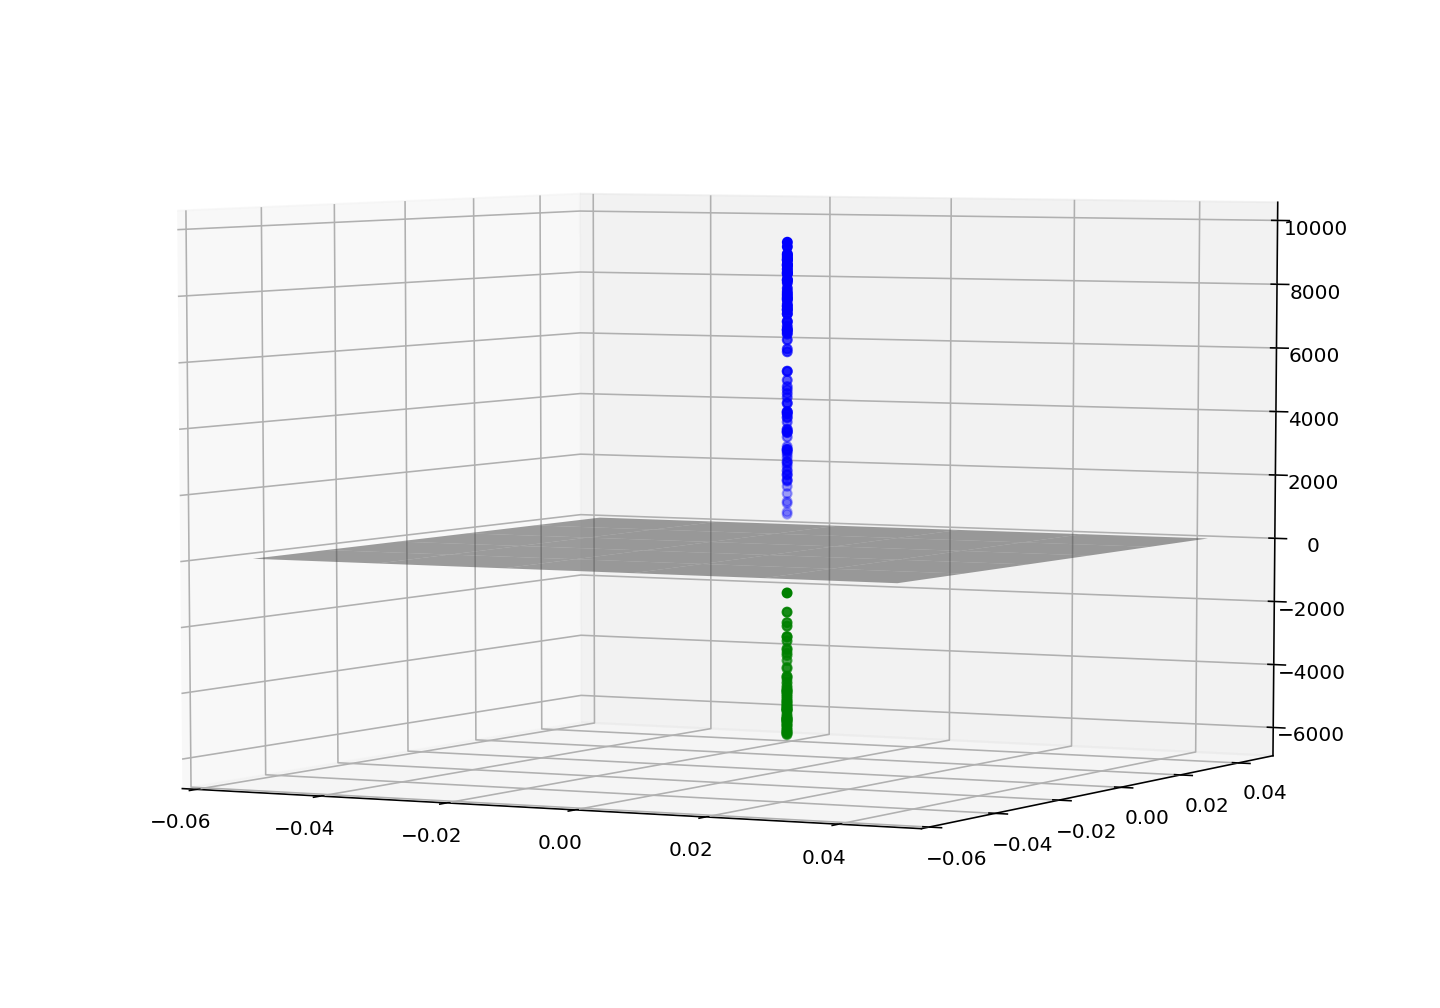

In [48]:
w = np.array([0, 0, 1])
new_data = dataset_3d # keeping labels
new_data[:,:3] = w * dataset_3d[:, :3]  # applying w on the data

# plotting
plot_3d(sacled_data)

# The Kernel Trick
Theformal definition of a kernel function:<br>
A function $K:\mathbb{R}^{n}\times\mathbb{R}^{n}\rightarrow\mathbb{R}$ is called a kernel if there exists a mapping function $\varphi:\mathbb{R}^{n}\rightarrow\mathbb{R}^{N}$ so that the following always holds:
$$K(x,y) = \varphi(x) \cdot \varphi(y)$$
In words, the result of applying the kernel on 2 vectors in low dimension is equivelant to applying a dot product on 2 vectors in a higher dimensions (sometimes really high - tens of thousands). <br><br>
The kernel helps us avoid these calculations in higher dimensions and therefore increace performance.<br><br>
Let's now find the kernel function of the above defined linear transportation $\varphi$:<br>
Let $x,y \in \mathbb{R^2}$
$$
\varphi\left(x\right)\cdot\varphi\left(y\right)=\varphi\left(x_{1},x_{2}\right)\cdot\varphi\left(y_{1},y_{2}\right)=$$$$\left(x_{1},x_{2},x_{1}^{2}+x_{2}^{2}\right)\cdot\left(y_{1},y_{2},y_{1}^{2}+y_{2}^{2}\right)=x_{1}\cdot y_{1}+x_{2}\cdot y_{2}+\left(x_{1}^{2}+x_{2}^{2}\right)\left(y_{1}^{2}+y_{2}^{2}\right)=$$$$x_{1}\cdot y_{1}+x_{2}\cdot y_{2}+x_{1}^{2}y_{1}^{2}+x_{1}^{2}y_{2}^{2}+x_{2}^{2}y_{1}^{2}+x_{2}^{2}y_{2}^{2}=\left(x_{1},x_{2}\right)\left(y_{1},y_{2}\right)+\left(x_{1}^{2},x_{2}^{2}\right)\left(y_{1}^{2},y_{2}^{2}\right)=$$$$\left(x_{1},x_{2}\right)\left(y_{1},y_{2}\right)+\left(x_{1},x_{2}\right)^{2}\left(y_{1},y_{2}\right)^{2}=\left(x,y\right)+\left(x^{2},y^{2}\right)
$$
So, instead of applying $\varphi$ on all the data and then dot product, we can apply $K$. In higher dimension mappings the performance will be incraeces dramatically.<br><br>

Let's implement $K(x,y) = (x,y) + (x^2,y^2)$:

In [50]:
def kernel_func(x, y):
    x_squared = x * x
    y_squared = y * y
    res = x @ y + x_squared @ y_squared
    return res

The only difference in the learning proccess will be:
$$o_d = \sum_{i=1} ^m \alpha_i t_i \left(\varphi\left(\overrightarrow{x_i}\right) \cdot \varphi\left(\overrightarrow{x_d}\right)\right) \Longrightarrow o_d = \sum_{i=1} ^m \alpha_i t_i K\left(\overrightarrow{x_i} \cdot \overrightarrow{x_d}\right) $$

In [51]:
def predict_kernel(x, alphas, data):
    kernelized_over_x = np.apply_along_axis(lambda instance: kernel_func(x, instance), 1, data[:,:-1])
    pred = 1 if (alphas[:-1] * data[:,-1] * kernelized_over_x).sum() + alphas[-1] >= 0 else -1
    return pred

In [52]:
%time alphas_3d_kernel = dual_perceptron(dataset_circles, iterations, predict_kernel)

CPU times: user 48.1 s, sys: 160 ms, total: 48.3 s
Wall time: 48.3 s


In [53]:
# test
dual_perceptron_test(dataset_circles, iterations, dataset_circles, predict_kernel)

accuracy rate: 1.0


Note that using the kernel saves computitions in higher dimensions (in our case $\mathbb{R}^2$.<br>
~1:30 mins reduced to ~00:45 mins.

## Plotting
Note that now we deal with larger numbers (the results $K$ returns):

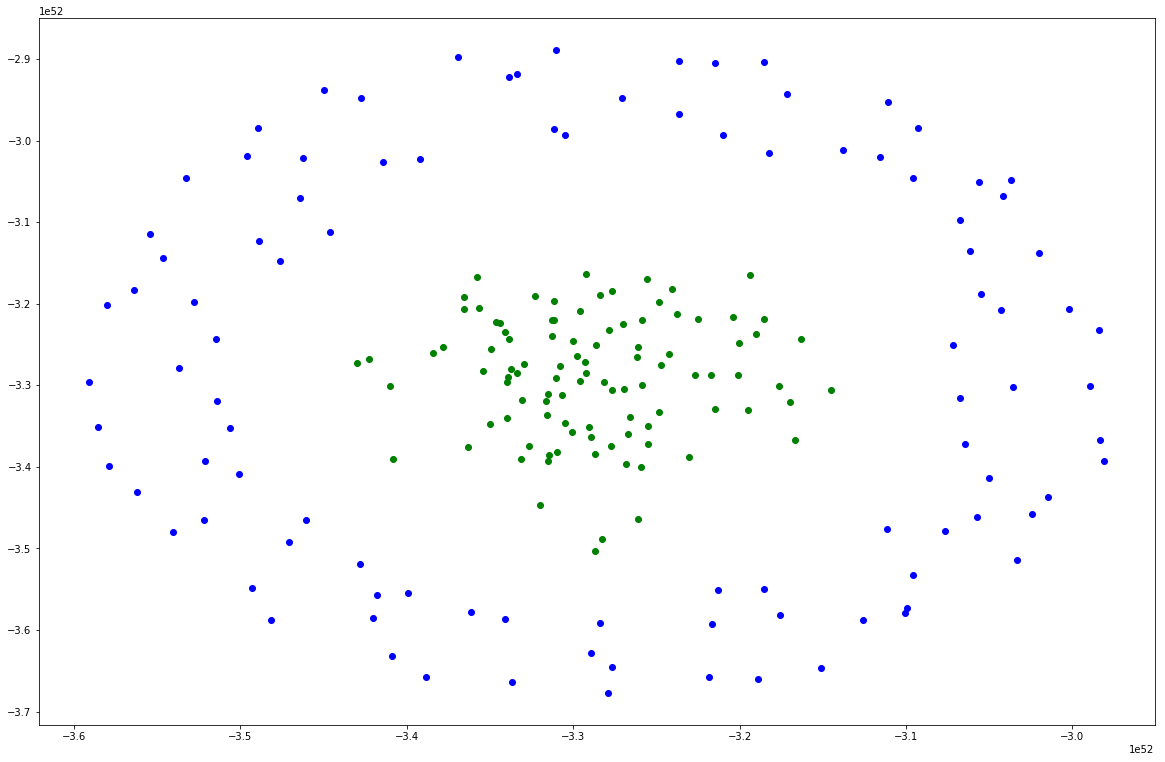

In [60]:
sacled_data = dataset_circles
sacled_data[:,:2] = dataset_circles[:,:-1] * ((alphas_3d_kernel[:-1] * dataset_circles[:,2]) @ dataset_circles[:,:-1]) + alphas_3d_kernel[-1]

# plotting
plot_2d(sacled_data, axes_lim=False)